Reweighting the dataset based on the following property: if class output (0 or 1) and attribute value are independant, we can compute P_exp(X(s)=b^class=1)=P(X(s)=b)*P(class=1) (what is expected). In the reality, if the data is biased, we have: P_obs(X(s)=b^class=1) which is different from P(X(s)=b)*P(class=1). We can reweight such that W = P_exp/P_obs to debiase the model
https://core.ac.uk/download/pdf/81728147.pdf

In [48]:
import numpy as np
np.random.seed(0)

from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

from IPython.display import Markdown, display

In [43]:
dataset_orig = GermanDataset(
    protected_attribute_names=['age'],           # this dataset also contains protected
                                                 # attribute for "sex" which we do not
                                                 # consider in this evaluation
    privileged_classes=[lambda x: x >= 25],      # age >=25 is considered privileged
    features_to_drop=['personal_status', 'sex'] # ignore sex-related attributes
)

# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

In [44]:
dataset_orig.label_names
dataset_orig.feature_names
dataset_orig_dataframe = dataset_orig.convert_to_dataframe()

In [4]:
dataset_orig_dataframe[0].head()

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,credit
0,6.0,1169.0,4.0,4.0,1.0,2.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,48.0,5951.0,2.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0
2,12.0,2096.0,2.0,3.0,1.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,42.0,7882.0,2.0,4.0,1.0,1.0,2.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,24.0,4870.0,3.0,4.0,1.0,2.0,2.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0


In [45]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
# compute statistical_parity_difference:  Pr(Y = 1 | D = \text{unprivileged})- Pr(Y = 1 | D = \text{privileged})
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.169905


In [46]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [7]:
assert np.abs(dataset_transf_train.instance_weights.sum()-dataset_orig_train.instance_weights.sum())<1e-6


In [47]:
dataset_transf_train.instance_weights

array([0.96229508, 0.96229508, 0.96229508, 0.96229508, 0.96229508,
       0.96229508, 0.96229508, 0.96229508, 1.25555556, 0.678     ,
       1.100625  , 1.100625  , 0.96229508, 0.96229508, 1.100625  ,
       0.96229508, 1.25555556, 1.100625  , 0.96229508, 0.96229508,
       0.96229508, 0.96229508, 0.96229508, 0.96229508, 0.96229508,
       1.100625  , 0.96229508, 0.96229508, 0.96229508, 0.678     ,
       0.96229508, 0.96229508, 0.678     , 1.100625  , 0.96229508,
       0.678     , 0.96229508, 0.96229508, 1.100625  , 0.96229508,
       1.100625  , 0.96229508, 0.96229508, 1.25555556, 0.96229508,
       0.678     , 1.100625  , 0.96229508, 0.96229508, 1.25555556,
       1.100625  , 1.100625  , 0.96229508, 0.96229508, 1.100625  ,
       0.96229508, 0.96229508, 0.96229508, 0.96229508, 0.96229508,
       1.100625  , 0.96229508, 0.96229508, 0.96229508, 0.96229508,
       0.96229508, 0.96229508, 1.100625  , 0.678     , 0.96229508,
       0.96229508, 0.96229508, 0.96229508, 0.96229508, 1.25555

In [9]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


### Training on original data

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [39]:

# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

In [41]:
lmod.predict_proba(X_valid)

array([[0.84920385, 0.15079615],
       [0.79456098, 0.20543902],
       [0.60552043, 0.39447957],
       [0.12402347, 0.87597653],
       [0.97323954, 0.02676046],
       [0.95222894, 0.04777106],
       [0.99691746, 0.00308254],
       [0.94838724, 0.05161276],
       [0.97515116, 0.02484884],
       [0.47986943, 0.52013057],
       [0.96626081, 0.03373919],
       [0.87039278, 0.12960722],
       [0.46321202, 0.53678798],
       [0.92427502, 0.07572498],
       [0.95658548, 0.04341452],
       [0.40524115, 0.59475885],
       [0.69944177, 0.30055823],
       [0.99012097, 0.00987903],
       [0.52466931, 0.47533069],
       [0.91138377, 0.08861623],
       [0.97526033, 0.02473967],
       [0.82238562, 0.17761438],
       [0.69527528, 0.30472472],
       [0.9868657 , 0.0131343 ],
       [0.91142961, 0.08857039],
       [0.68399147, 0.31600853],
       [0.96402141, 0.03597859],
       [0.88843106, 0.11156894],
       [0.55198852, 0.44801148],
       [0.77442925, 0.22557075],
       [0.

In [27]:
from sklearn import svm
clf_weights = svm.SVC(probability=True,gamma=1)
clf_weights.fit(X_train, y_train, sample_weight=dataset_orig_train.instance_weights)
y_train_pred_svm = clf_weights.predict(X_train)
dataset_orig_train_pred_svm = dataset_orig_train.copy()
dataset_orig_train_pred_svm.labels = y_train_pred_svm

#### Compute scores on test and validation data

In [28]:

dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1) #we only record the score of the positive class.
#the score of the negative class is consequently 1-positive_score

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

dataset_orig_valid_pred_svm = dataset_orig_valid.copy(deepcopy=True)
X_valid_svm = scale_orig.transform(dataset_orig_valid_pred_svm.features)
y_valid_svm = dataset_orig_valid_pred_svm.labels
dataset_orig_valid_pred_svm.scores = clf_weights.predict_proba(X_valid_svm)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred_svm = dataset_orig_test.copy(deepcopy=True)
X_test_svm = scale_orig.transform(dataset_orig_test_pred_svm.features)
y_test_svm = dataset_orig_test_pred_svm.labels
dataset_orig_test_pred_svm.scores = clf_weights.predict_proba(X_test_svm)[:,pos_ind].reshape(-1,1)

In [35]:
from aif360.metrics import ClassificationMetric
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

#balanced accuracy makes more sense if the dataset is not balanced between classes
print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr)) 
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.7261
Optimal classification threshold (no reweighing) = 0.8217


In [32]:
num_thresh = 100
ba_arr_svm = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred_svm.scores > class_thresh
    dataset_orig_valid_pred_svm.labels[fav_inds] = dataset_orig_valid_pred_svm.favorable_label
    dataset_orig_valid_pred_svm.labels[~fav_inds] = dataset_orig_valid_pred_svm.unfavorable_label
    
    classified_metric_orig_valid_svm = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred_svm, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr_svm[idx] = 0.5*(classified_metric_orig_valid_svm.true_positive_rate()\
                       +classified_metric_orig_valid_svm.true_negative_rate())

best_ind_svm = np.where(ba_arr_svm == np.max(ba_arr_svm))[0][0]
best_class_thresh_svm = class_thresh_arr[best_ind]

#balanced accuracy makes more sense if the dataset is not balanced between classes
print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr_svm)) 
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh_svm)

Best balanced accuracy (no reweighing) = 0.5136
Optimal classification threshold (no reweighing) = 0.8415


#### Predictions from the original test set at the optimal classification threshold¶


In [36]:
from tqdm import tqdm
from common_metrics import compute_metrics

display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

100%|██████████| 100/100 [00:00<00:00, 606.35it/s]

Classification threshold used = 0.8217
Balanced accuracy = 0.6900
Statistical parity difference = -0.0599
Disparate impact = 0.8755
Average odds difference = 0.0257
Equal opportunity difference = -0.2222
Theil index = 0.3409


In [37]:
from tqdm import tqdm
from common_metrics import compute_metrics

display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig_svm = []
disp_imp_arr_orig_svm = []
avg_odds_diff_arr_orig_svm = []

print("Classification threshold used = %.4f" % best_class_thresh_svm)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh_svm:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred_svm.scores > thresh
    dataset_orig_test_pred_svm.labels[fav_inds] = dataset_orig_test_pred_svm.favorable_label
    dataset_orig_test_pred_svm.labels[~fav_inds] = dataset_orig_test_pred_svm.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred_svm, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig_svm.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig_svm.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig_svm.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

 37%|███▋      | 37/100 [00:00<00:00, 357.98it/s]

Classification threshold used = 0.8415


100%|██████████| 100/100 [00:00<00:00, 402.56it/s]

Balanced accuracy = 0.5000
Statistical parity difference = 0.0000
Disparate impact = nan
Average odds difference = 0.0000
Equal opportunity difference = 0.0000
Theil index = 1.0986


average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv)) must be close to zero for the classifier to be fair.

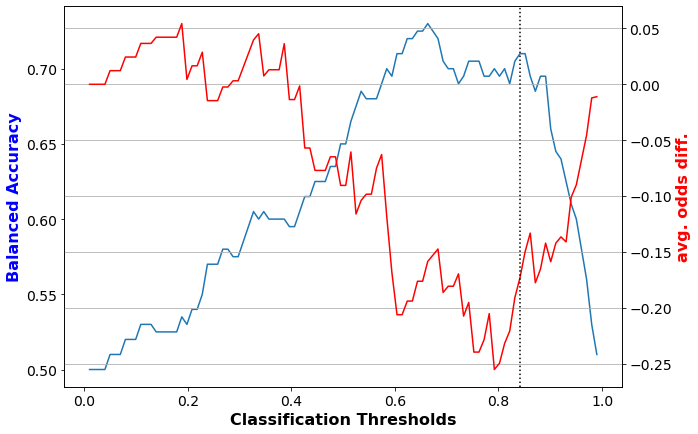

In [18]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.show()

#### Train classifier on transformed data

In [19]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

#### Inference on the test set

In [20]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

#### Predictions from the transformed test set at the optimal classification threshold

In [21]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

  2%|▏         | 2/100 [00:00<00:05, 16.54it/s]

Classification threshold used = 0.8415


100%|██████████| 100/100 [00:00<00:00, 393.60it/s]

Balanced accuracy = 0.6800
Statistical parity difference = -0.1193
Disparate impact = 0.7258
Average odds difference = -0.0276
Equal opportunity difference = -0.3778
Theil index = 0.3937


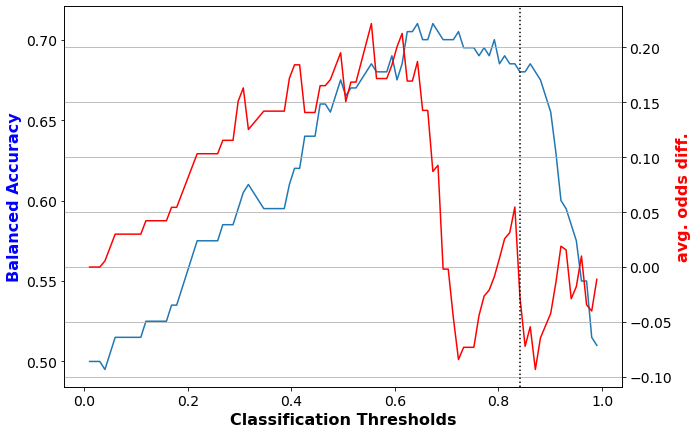

In [22]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)